In [2]:
import sys
sys.path += ['src', 'tests']  # add local directories

In [148]:
import time
import numpy as np
import matplotlib.pyplot as plt
import lp  # LP
import milp  # MILP
import heuristic
import problem_gen # API for problem generation

Напишем вспомогательные функции для анализа времени работы алгоритмов:
- **configure_problem** &mdash; создает генератор MILP/LP проблем с заданными параметрами
- **time_problem** &mdash; запускает алгоритм для решения задачи, и фиксирует его время работы

In [100]:
# we'll use this generator for running random tests
def configure_problem(n_vars: int, n_cons: int, bounds, obj) -> problem_gen.ProblemGenerator:
        return problem_gen.ProblemGenerator({
            'constraints_coeffs': 'uniform',
            'bounds': 'uniform',
            'obj_coeffs': 'uniform'
        },
        {
            'constraints_coeffs': [-10, 10],
            'bounds': bounds,
            'obj_coeffs': obj
        },
        n_vars,
        n_cons
    )

In [84]:
# we'll use this for benchmarking
N_ITERS = 20
def time_problem(gen: problem_gen.ProblemGenerator, function):
    sum = 0
    for _ in range(N_ITERS):
        t = gen.value().to_tableau()
        sum -= time.perf_counter()
        function(t)
        sum += time.perf_counter()
    return sum

Проанализируем время работы **primal simplex** метода для **LP** задач разного размера.

<Figure size 640x480 with 0 Axes>

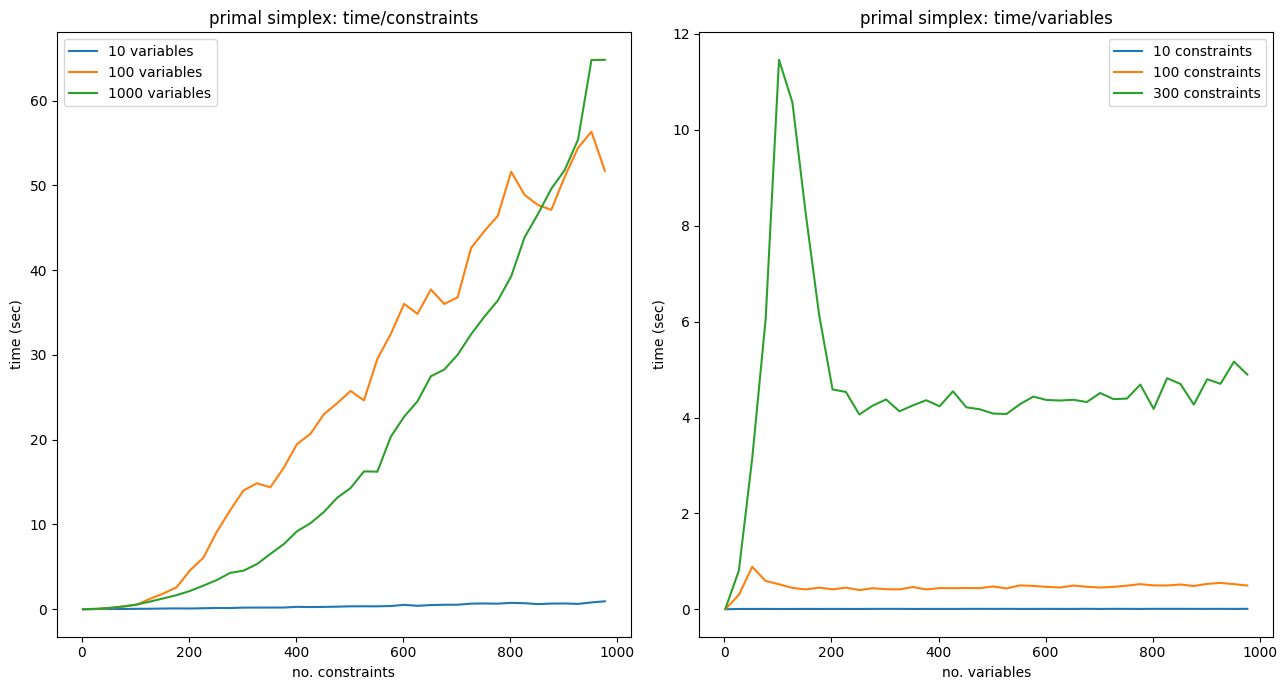

In [82]:
def make_plot(ax, iter, method, bounds, obj, xcv=True):
    x = []
    tm = []
    for nv, cv in iter:
        gen = configure_problem(nv, cv, bounds, obj)
        tm.append(time_problem(gen, method))
        x.append(cv if xcv else nv)
    ax.plot(x, tm)

def plot_method(name, method, bounds, obj):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))
    # no. constraints increases
    make_plot(ax[0], ((10, i) for i in range(2, maxc, step)), method, bounds, obj)
    make_plot(ax[0], ((100, i) for i in range(2, maxc, step)), method, bounds, obj)
    make_plot(ax[0], ((1000, i) for i in range(2, maxc, step)), method, bounds, obj)
    ax[0].set_title(f'{name}: time/constraints')
    ax[0].set_xlabel('no. constraints')
    ax[0].set_ylabel('time (sec)')
    ax[0].legend(['10 variables', '100 variables', '1000 variables'])
    # no. variables increases
    make_plot(ax[1], ((i, 10) for i in range(2, maxv, step)), method, bounds, obj, False)
    make_plot(ax[1], ((i, 100) for i in range(2, maxv, step)), method, bounds, obj, False)
    make_plot(ax[1], ((i, 300) for i in range(2, maxv, step)), method, bounds, obj, False)
    ax[1].set_title(f'{name}: time/variables')
    ax[1].set_xlabel('no. variables')
    ax[1].set_ylabel('time (sec)')
    ax[1].legend(['10 constraints', '100 constraints', '300 constraints'])
    fig.tight_layout()

M = 1_000_000_000
maxc = 1000  # max no. constraints
maxv = 1000  # max no. variables
step = 25   # increase step
plot_method('primal simplex', lp.run_primal_simplex, [0, M], [-M, M])

слева: *20 задач с 200 неравенствами решаются в сумме за 20 секунд, с 600 &mdash; за 30, c 800 &mdash; за 50, с 1000 &mdash; за 60 секунд*

справа: *наибольшее время работы получается, когда число исходных переменных примерно вдвое/втрое меньше, чем число неравенств. Для каждого неравенства создается **slack variable**, следовательно алгоритм работает медленнее всего, когда число переменных близко к числу неравенств*

Как видим, в среднем случае зависимость времени работы от количества неравенств является практически линейной, что совпадает с теоретическими оценками его времени работы в среднем. Аналогичный результат можем получить для **dual simplex** метода:



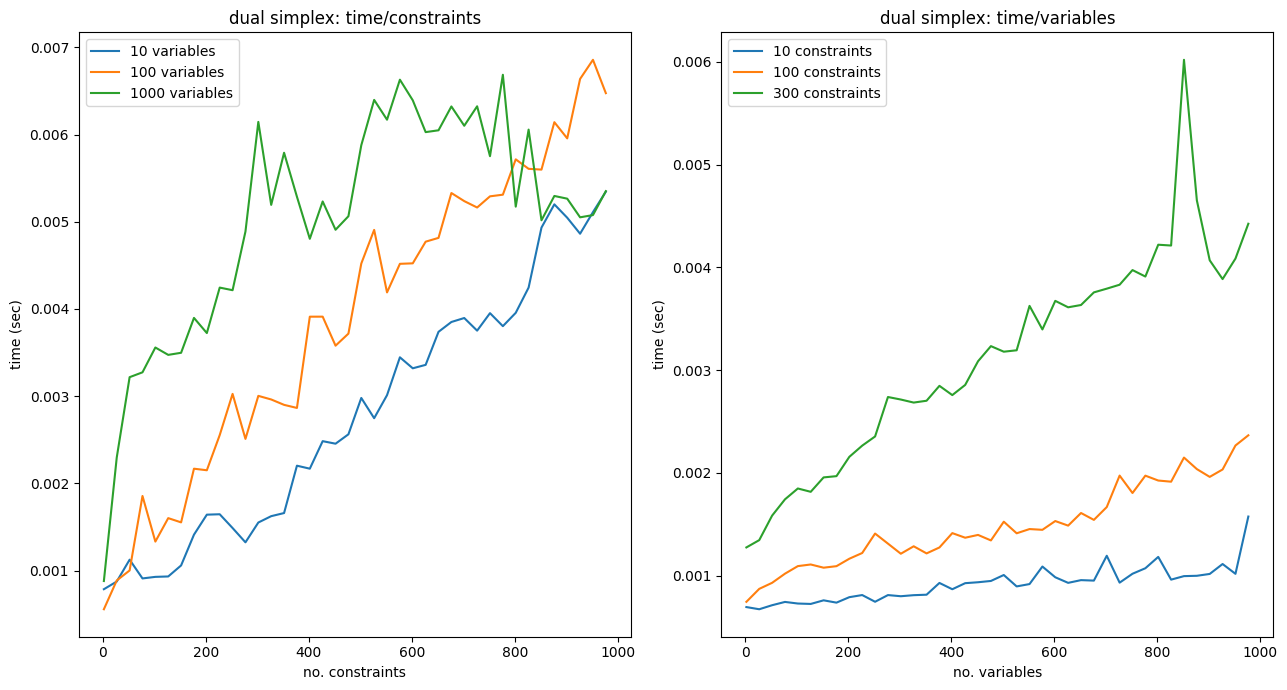

In [85]:
N_ITERS = 50
plot_method('dual simplex', lp.run_dual_simplex, [-M, M], [0, M])

Так же наблюдаем около-линейную зависимость времени работы от числа неравенств.

Теперь оценим работу **MILP-solver**'а на разных эвристиках.

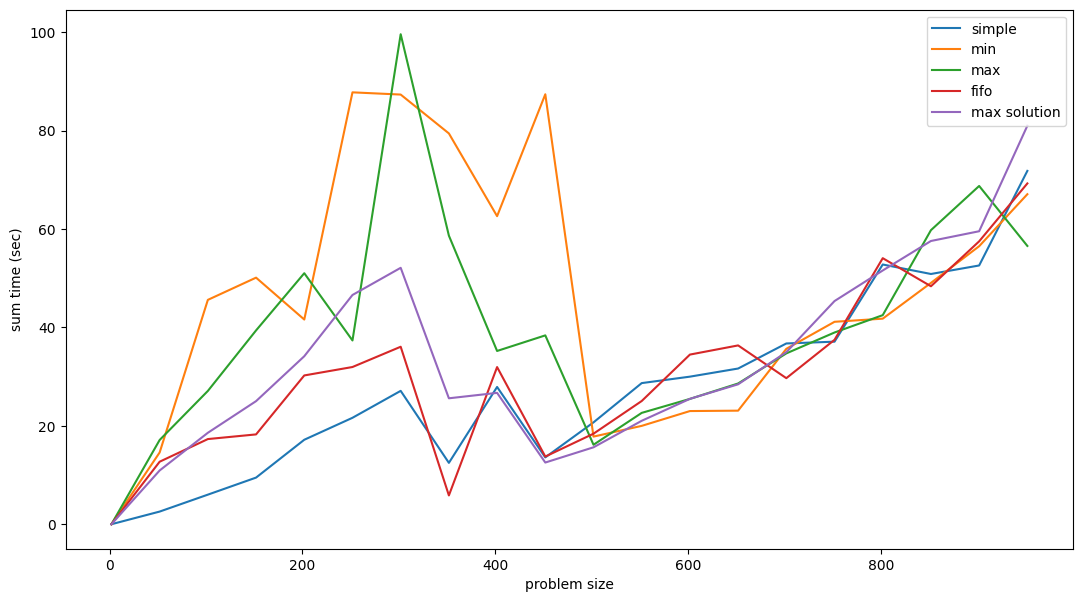

In [106]:
N_ITERS = 5
gen = configure_problem(10, 10, [0, M], [-M, M])
run_milp = lambda t, h: milp.solve_milp(t, [True for _ in range(t.variables_count)], h, heuristic.ga_simple)

def run_milp_heusteric(ax, h):
    make_plot(ax, ((i // 3, i) for i in range(2, 1000, 50)), lambda t: run_milp(t, h), [0, M], [-M, M])

fig, ax = plt.subplots(figsize=(13, 7))
run_milp_heusteric(ax, heuristic.gt_simple)
run_milp_heusteric(ax, heuristic.gt_min)
run_milp_heusteric(ax, heuristic.gt_max)
run_milp_heusteric(ax, heuristic.gt_fifo)
run_milp_heusteric(ax, heuristic.gt_max_solution)
ax.set_xlabel('problem size')
ax.set_ylabel('sum time (sec)')
ax.legend(['simple', 'min', 'max', 'fifo', 'max solution'])

Видим, что эвристики в среднем работают примерно одинаково (хотя некоторые хуже при меньших размерах, некоторые при больших).
Наблюдаем также, что время работы при больших размерах задачи в среднем более, чем линейное, но также не экспоненциальное.

В конце покажем, что несмотря на, в среднем, полиномиальную зависимость времени работы **simplex** метода от размера задачи, алгориитм не ограничен полиномом на примере следущего класса задач:

In [149]:
'''
max  100a+10b+c
s.t.   a           <= 1
     20a +   b     <= 100
    200a + 20b + c <= 10000
'''

def gen_problem(n):
    return {
        'func': lp.array(
            [10 ** (n - i - 1) for i in range(n)] +
            [0 for _ in range(n)]
        ),
        'matrix': lp.array([
                [2 * 10 ** (i - j) for j in range(i)] + [1] +
                [0 for _ in range(n - 1)] + [1] +
                [0 for _ in range(n - i - 1)] +
                [100 ** i]
            for i in range(n)
        ]),
        'basis': [i for i in range(n, n * 2)],
    }

np.set_printoptions(suppress=True)
print('objective:\n', gen_problem(3)['func'], sep='')
print('matrix:\n', gen_problem(3)['matrix'], sep='')
print('basis:\n', gen_problem(3)['basis'], sep='')

objective:
[100.  10.   1.   0.   0.   0.]
matrix:
[[    1.     0.     0.     1.     0.     0.     1.]
 [   20.     1.     0.     0.     1.     0.   100.]
 [  200.    20.     1.     0.     0.     1. 10000.]]
basis:
[3, 4, 5]


Text(0, 0.5, 'sum time (sec)')

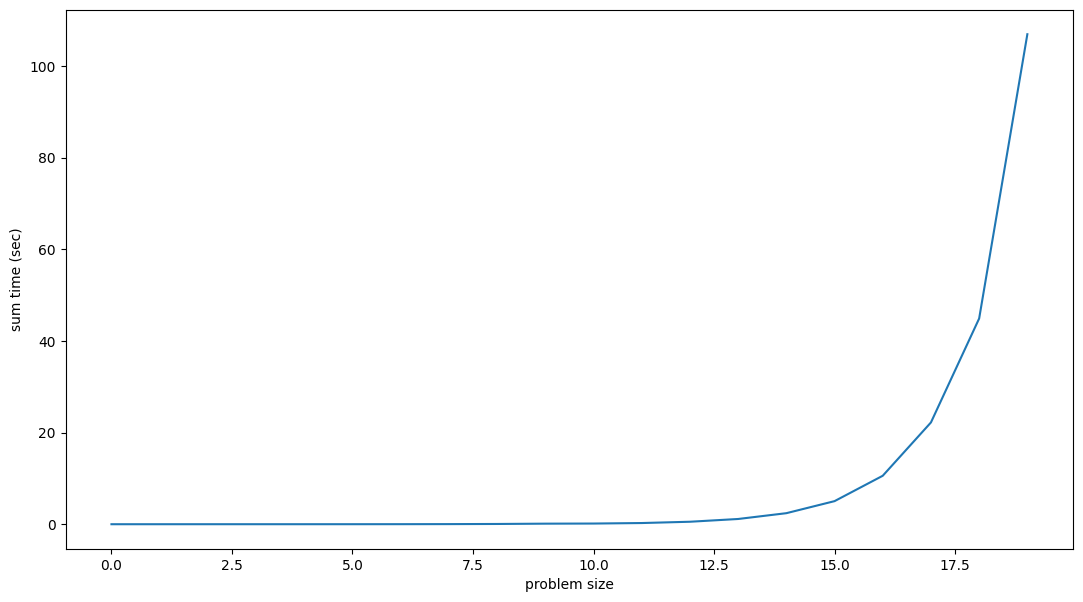

In [168]:
MAX_N = 20
tm = [0 for _ in range(MAX_N)]
for n in range(2, MAX_N):
    tm[n] = time.perf_counter()
    lp.run_primal_simplex(lp.Tableau.from_matrix(**gen_problem(n)))
    tm[n] = time.perf_counter() - tm[n]

fig, ax = plt.subplots(figsize=(13, 7))
ax.plot(range(MAX_N), tm)
ax.set_xlabel('problem size')
ax.set_ylabel('sum time (sec)')

В общем-то, нетрудно заметить, что на данном классе задач **simplex** метод работает за экспоненциальное время.

Проанализировав работу алгоритма, можем сделать вывод о том, что он хорошо работает на случайных тестах (за примерно линейное время); тем не менее, в целом, он не работает за $poly(n)$, так как есть классы задач, на которых алгоритм работает за экспоненциальное время.